# Recurrent Neural Networks

## Table of Contents
- [Theory](#theory)
- [Text Classification](#app-1)
- [Next Frame Prediction](#app-2)

## **Theory** <a class="anchor" id="theory"></a>

## RNNs - generalities

Given a sequence of $T \geq 2$ temporal states $x_0, x_2, \dots, x_{T-1}$, with $x_i \in \mathbb{R}^d$, $i\in \{0, T-1\}$, we want to extract task-related information from this sequence without "breaking" the temporal dimension. While MLPs clearly don't have a chance, CNNs may be able to grasp some temporal info by sliding a window along temporal dimension. However, given that the ordering of elements matter, *causal convolution* has to be applied s.t. the output of the current step doesn't depend on future states. 

In standard CNNs the output $y_i$ would depend on the following input context:
$$[x_{i - \lfloor K/2 \rfloor}, x_{i - \lfloor K/2 \rfloor + 1}, \dots, x_i, \dots, x_{i + \lfloor K/2 \rfloor - 1}, x_{i + \lfloor K/2 \rfloor}]$$
while in causal convolution the input context would be:
$$[x_{i - K - 1}, x_{i - K -2}, \dots, x_{i-1}, x_i]$$
, where $K \geq 3, K\%2 = 1$ represents the kernel/filter length. 

Long-term dependencies that may arise in the sequence $\{x_i\}_{i=1}^T$ would be lost due to the limiting context length $K$. On the other hand, increasing $K$ leads to a higher memory and computational cost, along with the possibility of bypassing short-term information.

**Recurrent Neural Networks (RNNs)** are a class of NNs tailored to temporal/sequential data, step-by-step processing each input $x_t$ using the same set of parameters, taking into account the *context* of previous steps.

<div style="text-align: center;">
  <img src="imgs/rnn.png" alt="description" width="1000"/>
  <figcaption>Diagram of a 1-layer RNN</figcaption>
</div>

**The same RNN cell** is used at each timestep, receiving the current input $x_i$ and previous state $h_{i-1}$ ($+$ any additional feature vector), and producing the current output $h_i$. In this way, multiple such RNN cells can be stacked, forming a multi-layer RNN, where upper layers receive as input the lower layers' outputs $h_i$ (the above figure corresponds to a single-layer RNN).

Of course, there are several disadvantages when using classic RNNs:
- Long-term dependencies may still be lost due to the continous fading of relevant info, since a single cell cannot grasp all history
- Lack of paralellism - we have to wait for previous state to finish computation (causality)

## The **LSTM** cell

[Long Short Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf) (LSTM) cells have been introduced to mitigate the problem of forgetting long-term dependencies in classic RNN cells. 

Their main component is the **cell state**, an additional recurrent feature vector that passes through all timestamps, having minor influence on each output $\rightarrow$ persists over multiple timesteps $\rightarrow$ encapsulates long-term past states.

Each LSTM cell is defined by 4 interconnected computational sub-modules:
1. *Forget Gate*:  $\{h_{t-1}, x_t\} \rightarrow$ mask $f_t$ representing **what to retain** from previous cell state $C_{t-1}$

2. *Information Gate*: $\{h_{t-1}, x_t\} \rightarrow$ mask $i_t$, along with new cell state candidates $\tilde{C}_{t-1}$. Mask $i_t$ decides what to keep from current candidates $\tilde{C}_{t-1}$ 

3. *State Update* (**Cell State**): cell state update based on masks $\{f_t, i_t\}$

4. *Output Gate*: computes the final features representative for the current timestep. Roughly speking, this gate decides which elements from the cell state are going to the output at the current timestep.

<div style="text-align: center;">
  <img src="imgs/lstm.png" alt="description" width="1000"/>
  <figcaption>Information flow in a LSTM cell, for a single timestep.</figcaption>
</div>

### Other variants:
- Bidirectional LSTM
- [ConvLSTM](https://proceedings.neurips.cc/paper/2015/hash/07563a3fe3bbe7e3ba84431ad9d055af-Abstract.html)
- [Self-Attention LSTM](https://ojs.aaai.org/index.php/AAAI/article/view/6819)

---

## *{Self, Cross}* - **Attention**

Although not neccessarely related to recurrent stuff, **attention mechanisms** have been utilised in various domains in order to enforce the representational power through similarity matching strategies between different parts of input data.

Neural machine translation has been among the first fields working with sequential data to benefit from [Self-Attention Mechanisms](https://arxiv.org/pdf/1409.0473), showing that using a fixed-length vector representation between an encoder and a deocder comes with a significant bottleneck. In contrast, self-attention allowed a model to automatically (soft-)search for parts of a source sentence relevant for predicting a target word.

The **multi-head self-attention** works as follows:

1. For each head, the input sequential data $X\in\mathbb{R}^{T \times D}$, with $T$ being the temporal dimension (or any multide of dimensions on which we can define some "ordering"), is linearly transformed into **query / key / value** tensors:
$$Q_h \gets X W_h^{Q}, \quad K_h \gets X W_h^{K}, \quad V_h \gets X W_h^{V}$$ 
$$W_h^{Q}, W_h^{K}, W_h^{V} \in \mathbb{R}^{D \times D'}$$
$$Q, K, V \in \mathbb{R}^{T\times D'}$$
$$h \in \{1, \dots, n_{heads}\}$$

2. Similarity scores are computed between keys and queries *Softmax*:
$$A_h \gets \text{\texttt{softmax}}(Q_h K_h^T), \quad A_h \in [0, 1]^{T\times T}$$

3. These scores are used to mix the temporal entries of $V_h$, computing at each timestep a convex combination of the previous values:
$$Z_h \gets A_h V_h, \quad Z_h \in \mathbb{R}^{T\times D}$$

4. All outputs $Z_h$ from each head $h$ are concatenated and multiplied by a final output matrix $W_o \in \mathbb{R}^{D' \cdot n_{heads} \times D}$, resulting the final features $Z$:
$$Z \gets \big[Z_1 \Vert Z_2 \Vert \dots \Vert Z_{n_{heads}}\big] W_o, \quad Z \in \mathbb{R}^{T \times D}$$

<div style="text-align: center;">
  <img src="imgs/self_att.png" alt="description" width="1000"/>
  <figcaption><b>Left: </b>Computing Q, K, V. <b>Right: </b>Multi-head self-attention. Sub-images modified from <a href="https://jalammar.github.io/illustrated-transformer/">here</a></figcaption>
</div>

(Multi-Head) **Cross-Attention** differs in that two temporal sources are analysed (not neccessarely having equal $T$), and between which attention scores $A_h$ are computed.

Cross-Attention has been mostly used in multi-modal learning, computing similarities between encoded modalities in order to retrieve relevant responses. Most notably, [Contrastive Language-Image Pretraining](CLIP) combines text and images to create zero-shot classifiers. Another example is [CrossViT](https://openaccess.thecvf.com/content/ICCV2021/papers/Chen_CrossViT_Cross-Attention_Multi-Scale_Vision_Transformer_for_Image_Classification_ICCV_2021_paper.pdf) which attends to features resulted from two transformer encoders, merging them into a multi-scale representation.

---

## **Movie review classification** <a class="anchor" id="app-1"></a>

We'll use `torchtext` package to download and prepare our data. 

In [1]:
import torch
torch.__version__

'2.0.1'

Install `torchtext` without overriding the current `torch` install. Take at look at [this table](https://pypi.org/project/torchtext/) and [these releases](https://github.com/pytorch/text/releases) to make sure you install the right `torchtext` version for your current `torch` installation. You'll also need `torchdata` - check out [its releases](https://github.com/pytorch/data/releases) to see which version you need. `poratlocker==2.8.2` is required, according to [this fix](https://github.com/pytorch/text/issues/2172#issuecomment-1808401332).

In [2]:
!pip install torchtext==0.15.2 torchdata==0.6.1 
!pip install portalocker==2.8.2

Load the **SST2** dataset, containing pairs of `sentence, {0, 1} labels`:

In [3]:
import torch
import torchtext
from torchtext.datasets import SST2

train_ds = SST2(root="data/", split="train")
test_ds = SST2(root="data/", split="dev")

label_names = {
    0: "bad",
    1: "good"
}

In [4]:
seen_classes = {}
max_per_class_samples = 3

for sample in iter(test_ds):
    x, y = sample

    if y not in seen_classes.keys():
        print(f"Class y={y} ({label_names[y]}): {x}")
        seen_classes[y] = 1
    else:
        if seen_classes[y] < max_per_class_samples:
            print(f"Class y={y} ({label_names[y]}): {x}")
            seen_classes[y] += 1

Class y=1 (good): it 's a charming and often affecting journey .
Class y=0 (bad): unflinchingly bleak and desperate
Class y=1 (good): allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .
Class y=1 (good): the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .
Class y=0 (bad): it 's slow -- very , very slow .
Class y=0 (bad): a sometimes tedious film .


## Sentence Pre-Processing

We'll pre-process each sequence in the following manner:
$$\text{Sentence} \xrightarrow{\text{Tokenizer}} [\text{Words}] \xrightarrow{Vocabulary} [\text{Word Indexes}]$$
For that, we'll need a basic english sentence (word) breaker, and a vocabulary to assigning an integer index to each unique word in our corpus.

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(ds):
    for text, y in ds:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_ds), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [13]:
x, y = next(iter(test_ds))

print(f"label-sentence: {label_names[y]} \ {x}")
print("Tokenized sequence: ", tokenizer(x))
print("Vocabulary indices for the tokenized sequence: ", vocab(tokenizer(x)))

label-sentence: good \ it 's a charming and often affecting journey .
Tokenized sequence:  ['it', "'", 's', 'a', 'charming', 'and', 'often', 'affecting', 'journey', '.']
Vocabulary indices for the tokenized sequence:  [13, 7, 9, 3, 296, 4, 144, 1411, 596, 6]


Since we cannot directly stack multiple tokenized sequences into a `(batch_size, n_words)` tensor of indices, we'll need to pad each sentence with `<unk>` characters until the largest n.o. words in a batch is reached.

We'll do this by passing a custom `collate_fn` to the dataloaders, which will automatically perform this operation on each extracted batch of sentences.

In [15]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# This will be applied over each sentence -> just like the above example
text_processor = lambda x: vocab(tokenizer(x)) 
label_processor = lambda y: int(y)

# This will be applied over each extracted batch of sentences
def collate_fn(batch):
    label_list, text_list, length_list = [], [], []
    for _text, _label in batch:
        label_list.append(label_processor(_label))
        processed_text = torch.LongTensor(text_processor(_text))
        text_list.append(processed_text)
        length_list.append(len(processed_text))
    
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab["<unk>"]) # returns a (B, T_max) tensor of indices
    length_list = torch.LongTensor(length_list)

    # need to sort in descending order - s.t. the first element has the highest length in the batch
    # this is useful for what will follow in the training phase
    length_list, perm_idx = length_list.sort(0, descending=True)
    text_list = text_list[perm_idx]
    label_list = label_list[perm_idx]
    
    return text_list.to(device), label_list.to(device), length_list.to(device)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

Using cpu


In [16]:
for batch in train_loader:
    x, y, lengths = batch

    bs, max_size = x.shape[0], x.shape[1]

    print("Batch size: ", bs)
    print("Max size in batch: ", max_size)
    print("Batch tensor shape: ", x.shape)
    print("All lenghts in batch: ", lengths)

    print("First 3 examples in batch:")
    for i in range(3):
        print("-> ", x[i].cpu().numpy())
    
    break

Batch size:  64
Max size in batch:  35
Batch tensor shape:  torch.Size([64, 35])
All lenghts in batch:  tensor([35, 25, 25, 25, 21, 20, 19, 18, 18, 18, 17, 17, 16, 15, 13, 12, 11, 11,
        10, 10, 10,  9,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  6,  6,  6,  6,
         5,  5,  5,  5,  5,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  2,  2,  2,  2,  2,  1,  1,  1,  1])
First 3 examples in batch:
->  [  10    1  157    5   20  702   78   22  303    8 4480   68  457   25
    1  634   12 1196    5   22    2   32   18 4507    2   32   18 3898
    2   32   18  679 5348 1825    6]
->  [  150  4723   173    35   233  5142    92     2    42  2907 12467   238
     2    23    13     7     9   509    16   401   507     8   168    32
    95     0     0     0     0     0     0     0     0     0     0]
->  [  40  923   12    3 4301 6637    2 7732    3 1538    5 1020 5327 4975
   25   36  131    2    4 1882 3623   22  116  550 7933    0    0    0
    0    0    0    0    0    0   

A `nn.Embedding` layer is used to convert these integer indexes into float tensor representations. An embedding layer works as a lookup table, mapping word indexes to real-valued tensors, which are optimized during training along with all the other parameters.

<div style="text-align: center;">
  <img src="imgs/embedd.png" alt="description" width="800"/>
  <figcaption>Simplified diagram of sentence embedding.</figcaption>
</div>

In [18]:
import torch.nn as nn

example_embedd = nn.Embedding(len(vocab), 50)
embedded_x = example_embedd(x.cpu()) # computes the embedding separately and independently for each word (index)
bs, seq, emb = embedded_x.shape
print(f"Batch \ Seq.Len \ Embedding dim: {bs} \ {seq} \ {emb}")

Batch \ Seq.Len \ Embedding dim: 64 \ 35 \ 50


## Build and Train Embeddings + LSTM

In order to efficiently work with batches containing variable-length data (effective length) we'll need to `pad-pack` each batch s.t. a batch is presented to the LSTM as follows:

<div style="text-align: center;">
  <img src="imgs/pack_padded.png" alt="description" width="1200"/>
  <figcaption>Pack-padding strategy for training on variable-sized sentences.</figcaption>
</div>

In [19]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedd_size, num_layers, lstm_hidden_dim, n_classes, 
                 bidirectional=False, predict_on_output=True):
        super(RNNClassifier, self).__init__()

        self.embedd_size = embedd_size
        self.embedding = nn.Embedding(vocab_size, embedd_size, padding_idx=0, scale_grad_by_freq=False,
                                     max_norm=1.0) # this receives indices and returns float tensor representations

        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(embedd_size, lstm_hidden_dim, 
                            dropout=0., num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        # We can choose between predicting on the output tensor, or on the hidden state
        if predict_on_output:
            if bidirectional:
                # In the bidirectional case, we'll have two two outputs - one for ->, another for <-
                self.out_dim = lstm_hidden_dim * 2
            else:
                self.out_dim = lstm_hidden_dim
        else:
            # predict on the concatenation of last hidden states, from each layer
            if bidirectional:
                self.out_dim = lstm_hidden_dim * num_layers * 2
            else:
                self.out_dim = lstm_hidden_dim * num_layers

        self.out_classification = nn.Sequential(
            nn.Linear(self.out_dim, n_classes) 
        )
        
        self.predict_on_output = predict_on_output
        self.num_layers = num_layers
    
    def forward(self, x, lengths):
        embeddings = self.embedding(x)
        
        # need to pack-padd embeddings, in order to exclude padded values from computation in LSTM
        embeddings_ = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths.cpu().numpy(), batch_first=True).to(device)

        # hidden and cell states will be returned for each LSTM layer - (num_layers, batch_size, lstm_hidden_dim)
        out, (hidden_state, cell_state) = self.lstm(embeddings_)

        # unpack padded output sequence
        out_, lens_unpacked  = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        if self.predict_on_output:
            # take the output for each element in the batch, at the index of len_sequence - 1 (last word)
            preds = self.out_classification(
                        torch.gather(
                            out_, dim=1, 
                            index=(lens_unpacked - 1).view(-1, 1).unsqueeze(2).expand(-1, -1, out_.size(-1)).to(out_.device)
                        ).squeeze()
                    )
        else:
            # Classify on the concatenation of hidden_states from each layer
            preds = self.out_classification(
                        torch.cat([hidden_state[i] for i in range(self.num_layers)], dim=1)
                    )  
        
        return preds

Define hyperparameters:

In [20]:
embedd_size = 50
num_layers = 2
lstm_hidden_dim = 32
bidirectional = False
predict_on_output = True
n_classes = 2

epochs = 5
lr = 1e-3
l2 = 0

In [23]:
model = RNNClassifier(len(vocab), 
                      embedd_size, 
                      num_layers, 
                      lstm_hidden_dim, 
                      n_classes,
                      bidirectional=bidirectional,
                      predict_on_output=predict_on_output).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

folder_path = "models/sst2/"
file_name = "model.pth"

print("Model output shape: ", model(x, lengths).shape)

Model output shape:  torch.Size([64, 2])


After training, you'll observe some overfitting - you can play with $\ell_2$-regularization, but be careful not to assign a too big weighting factor, otherwise it will not learn at all.

In [24]:
import importlib
import torch_utils
importlib.reload(torch_utils)

train_losses, test_losses = torch_utils.train_loop(
    model, train_loader, optimizer, criterion, epochs, 
    test_loader=test_loader, 
    device=device, 
    folder_path=folder_path, 
    file_name=file_name
)

0it [00:00, ?it/s]/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
1053it [00:15, 69.57it/s]
14it [00:00, 119.76it/s]


Epoch 1/5: train_loss=0.21116176960460933 train_acc=0.9201918365528813 test_loss=0.466987030846732 test_acc=0.823394495412844


1053it [00:15, 67.53it/s]
14it [00:00, 122.89it/s]


Epoch 2/5: train_loss=0.17473907431928973 train_acc=0.9344756418061144 test_loss=0.5304145451102938 test_acc=0.8222477064220184


1053it [00:15, 69.56it/s]
14it [00:00, 127.44it/s]


Epoch 3/5: train_loss=0.14936892355014797 train_acc=0.9441862536934476 test_loss=0.5338231261287417 test_acc=0.823394495412844


1053it [00:15, 69.47it/s]
14it [00:00, 128.86it/s]


Epoch 4/5: train_loss=0.12984908288141317 train_acc=0.950511514647582 test_loss=0.6557638453585761 test_acc=0.8165137614678899


1053it [00:15, 68.14it/s]
14it [00:00, 126.97it/s]

Epoch 5/5: train_loss=0.11394708342885586 train_acc=0.956228006354957 test_loss=0.7081157394817897 test_acc=0.8119266055045872


In [25]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

model.load_state_dict(
    torch.load(os.path.join(folder_path, file_name))["state_dict"]
)

input_text = widgets.Text(placeholder='Type here...', description='Input:', layout = widgets.Layout(width='1000px'))
output_text = widgets.Output()

def predict_and_update(change):
    with output_text:
        if len(change.new) > 0:
            clear_output()
            sentence = change.new
            length = len(tokenizer(sentence))
            tokens = torch.LongTensor(text_processor(sentence))[None, ...].to(device)
            length = torch.LongTensor([length]).to(device)
            
            print('Prediction:', label_names[model(tokens, length).argmax().item()])

input_text.observe(predict_and_update, names='value')

display(input_text)
display(output_text)

Text(value='', description='Input:', layout=Layout(width='1000px'), placeholder='Type here...')

Output()

### Analysing word embeddings

The `nn.Embedding` layer has optimized a $W \in \mathbb{R}^{|\texttt{Vocab}| \times \texttt{embedd\_size}}$ matrix containing representations for each word in our vocabulary. We can compute distances between the embedding of a word and each entry in the matrix to get the most similar or least similar words.

In [26]:
def get_top_k(k, emb_word, vocab, embeddings, device, most_similar=True, distance="l2", lookup_token=None, return_res=False):
    if distance == "l2":
        distances = torch.norm(embeddings - emb_word, p=2, dim=1)
    elif distance == "cosine":
        distances = 1 - torch.nn.functional.cosine_similarity(emb_word, embeddings, dim=1)
    else:
        raise ValueError(f"Unknown distance {distance}.")
    
    idx_sorted = torch.argsort(distances)

    if most_similar:
        if return_res:
            if lookup_token:
                return [lookup_token(idx_sorted[i + 1]) for i in range(k)]
            else:
                return [vocab.lookup_token(idx_sorted[i + 1]) for i in range(k)]
        else:
            print(f"Top k similar ({distance}): ", end=" ")
            for i in range(k):
                if lookup_token:
                    print(lookup_token(idx_sorted[i + 1]), end=", ")
                else:
                    print(vocab.lookup_token(idx_sorted[i + 1]), end=", ") # if i == 0, it would return that actual word
            print("\n")
    else:
        if return_res:
            if lookup_token:
                return [lookup_token(idx_sorted[-(i + 1)]) for i in range(k)]
            else:
                return [vocab.lookup_token(idx_sorted[-(i + 1)]) for i in range(k)]
        else:
            print(f"Top k disimilar ({distance}): ", end=" ")
            for i in range(k):
                if lookup_token:
                    print(lookup_token(idx_sorted[-(i + 1)]), end=", ") 
                else:
                    print(vocab.lookup_token(idx_sorted[-(i + 1)]), end=", ") # if i == 0, it would return that actual word    
            print("\n")

In [27]:
word = "desperate"
idx_word = vocab[word]
emb_word = model.embedding(torch.LongTensor([idx_word]).to(device))
k = 5

get_top_k(k, emb_word, vocab, model.embedding.weight, device)
get_top_k(k, emb_word, vocab, model.embedding.weight, device, most_similar=False)
get_top_k(k, emb_word, vocab, model.embedding.weight, device, distance="cosine")
get_top_k(k, emb_word, vocab, model.embedding.weight, device, most_similar=False, distance="cosine")

Top k similar (l2):  inhale, virulent, meanspirited, flag, sitcom-worthy, 

Top k disimilar (l2):  brush, compulsively, forceful, sublime, head-turner, 

Top k similar (cosine):  plain, soliloquies, vulgar, market, kirkegaard, 

Top k disimilar (cosine):  rewarded, superb, unflinching, definitely, department, 



In [29]:
analogies_to_explore = [
    ("love", "romance", "hate"),
    ("killing", "action", "laughing"),
    ("man", "chef", "woman"),  
    ("man", "doctor", "woman")
]

for analogy in analogies_to_explore:
    word_a, word_b, word_c = analogy
    idx_word_a, idx_word_b, idx_word_c = vocab[word_a], vocab[word_b], vocab[word_c]
    
    emb_word_a = model.embedding(torch.LongTensor([idx_word_a]).to(device))
    emb_word_b = model.embedding(torch.LongTensor([idx_word_b]).to(device))
    emb_word_c = model.embedding(torch.LongTensor([idx_word_c]).to(device))

    new_embed = emb_word_b - emb_word_a + emb_word_c
    
    result = get_top_k(3, new_embed, vocab, model.embedding.weight, device, distance="cosine", return_res=True)
    result = list(map(str.upper, result))
    
    if result:
        print(f"{word_a.upper()} is to {word_b.upper()} as {word_c.upper()} is to {result}")
    else:
        print("Some words in the analogy are not in the vocabulary.")

LOVE is to ROMANCE as HATE is to ['MISSED', 'BAD', 'WINDS']
KILLING is to ACTION as LAUGHING is to ['SINCE', 'ATTRACTIVE', 'THROUGHOUT']
MAN is to CHEF as WOMAN is to ['LITTLE-REMEMBERED', 'WHY', 'ANOTHER']
MAN is to DOCTOR as WOMAN is to ['CONVENIENCE', 'FLUX', 'JOSE']


Things that have affected the quality of the above results:
- Vocabulary was too simple - only words and phrases related to a single subject (i.e. movie reviews)
- The classification task is not too broad - it doesn't help that much in learning meaningful relationships between embeddings 

### Compare with [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) embeddings

[Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) is an algorithm for learning vector representations, just like jointly training a `nn.Embedding`layer along with other sub-modules in a given task.

In [30]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

word = "desperate"
emb_word = glove[word]
k = 5

get_top_k(k, emb_word, None, glove.vectors, device, lookup_token=lambda idx: glove.itos[idx])
get_top_k(k, emb_word, None, glove.vectors, device, most_similar=False, lookup_token=lambda idx: glove.itos[idx])
get_top_k(k, emb_word, None, glove.vectors, device, distance="cosine", lookup_token=lambda idx: glove.itos[idx])
get_top_k(k, emb_word, None, glove.vectors, device, most_similar=False, distance="cosine", lookup_token=lambda idx: glove.itos[idx])

Top k similar (l2):  desperately, vain, wanting, trouble, weary, 

Top k disimilar (l2):  non-families, 202-383-7824, 20003, www.star, officership, 

Top k similar (cosine):  desperately, trouble, wanting, vain, weary, 

Top k disimilar (cosine):  landolt, preus, icct, yisheng, daojiong, 



In [31]:
for analogy in analogies_to_explore:
    word_a, word_b, word_c = analogy
    emb_word_a = glove[word_a]
    emb_word_b = glove[word_b]
    emb_word_c = glove[word_c]

    new_embed = emb_word_b - emb_word_a + emb_word_c
    
    result = get_top_k(3, new_embed, None, glove.vectors, device, distance="cosine", return_res=True, lookup_token=lambda idx: glove.itos[idx])
    result = list(map(str.upper, result))
    
    if result:
        print(f"{word_a.upper()} is to {word_b.upper()} as {word_c.upper()} is to {result}")
    else:
        print("Some words in the analogy are not in the vocabulary.")

LOVE is to ROMANCE as HATE is to ['STEREOTYPING', 'HATE', 'MONGERING']
KILLING is to ACTION as LAUGHING is to ['LAUGHING', 'BIT', 'TUNE']
MAN is to CHEF as WOMAN is to ['WAITRESS', 'DECORATOR', 'STYLIST']
MAN is to DOCTOR as WOMAN is to ['NURSE', 'CHILD', 'WOMAN']


We see that these embeddings perform much better, while also revealing some gender bias.

---

## **Forecasting with Seq2Seq** <a class="anchor" id="app-2"></a>

We'll be using the [Seq2Seq](https://arxiv.org/pdf/1409.3215) architecture (also known as "Sutskever model") to predict the next frames from [Moving MNIST dataset](https://paperswithcode.com/dataset/moving-mnist). Seq2Seq models have been used for sequence-to-sequence translation (hence the name), mostly in LanguageA-to-LanguageB tasks. Check out [this tutorial notebook](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) on german-to-english translation.

We'll adapt the Seq2Seq architecture to work on 2D data (frames) instead of tokens, by utilizing a $2D \rightarrow 1D$ **encoder** that will process all input frames independently, followed by a LSTM network to model the sequence of temporal features, and a final $1D \rightarrow 2D$ **decoder** that will translate the predicted 1D features to 2D future frames.

Check out [these nice visuals](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html) on how Seq2Seq works (including adding attention).

In [32]:
from torchvision.datasets import MovingMNIST

split_ratio = 10

transform = lambda x: x / 255.0

first_frames = MovingMNIST(root="data/", split="train", download=True, split_ratio=split_ratio, transform=transform)
last_frames = MovingMNIST(root="data/", split="test", download=True, split_ratio=split_ratio, transform=transform)

100%|██████████| 819200096/819200096 [02:27<00:00, 5544025.59it/s]


We'll be using the first 10 frames as input, and our task is to predict the following 10 frames.

In [36]:
bs_ = 16

print("Shape of first frames (known): ", first_frames[:bs_].shape)
print("Shape of last frames (unknown): ", last_frames[:bs_].shape)
print(f"Value range: [{first_frames[:bs_].min()}, {first_frames[:bs_].max()}]")

Shape of first frames (known):  torch.Size([16, 10, 1, 64, 64])
Shape of last frames (unknown):  torch.Size([16, 10, 1, 64, 64])
Value range: [0.0, 1.0]


In [37]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from IPython.display import display
import numpy as np

i = np.random.randint(0, len(first_frames))
all_frames = np.concatenate((first_frames[i], last_frames[i]), axis=0)

def display_frame(frame_number):
    plt.imshow(all_frames[frame_number].squeeze(), cmap="gray")
    plt.axis('off')
    plt.show()

frame_slider = widgets.IntSlider(min=0, max=all_frames.shape[0] - 1, step=1, description='Frame')
widgets.interact(display_frame, frame_number=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=19), Output()), _dom_classes=('widget-intera…

<function __main__.display_frame(frame_number)>

### Split and Create train/test loaders

In [39]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, Dataset, DataLoader

class CustomMMNIST(Dataset):
    def __init__(self, first_fs, last_fs):
        self.first_ = first_fs
        self.last_ = last_fs

        assert len(self.first_) == len(self.last_)
    
    def __len__(self):
        return len(self.first_)

    def __getitem__(self, idx):
        return self.first_[idx], self.last_[idx]

indexes = list(range(len(first_frames)))
train_idx, test_idx = train_test_split(indexes, test_size=0.2, random_state=42)  

first_train, first_test = Subset(first_frames, train_idx), Subset(first_frames, test_idx)
last_train, last_test = Subset(last_frames, train_idx), Subset(last_frames, test_idx)

train_mnist = CustomMMNIST(first_train, last_train)
test_mnist = CustomMMNIST(first_test, last_test)

train_loader = DataLoader(train_mnist, batch_size=32, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=32, shuffle=False)

In [40]:
len(train_mnist), len(test_mnist)

(8000, 2000)

### Construct Seq2Seq model

The usual architecture of Seq2Seq is depicted as follows:

<div style="text-align: center;">
  <img src="imgs/seq2seq.png" alt="description" width="1200"/>
  <figcaption>Seq2Seq architecture. <a href="https://blog.suriya.app/2016-12-31-practical-seq2seq/">Source</a></figcaption>
</div>

We have an RNN encoder that processes the input sequence, followed by another RNN decoder that receives the final states of the encoder and generates the output sequence, element-by-element, using the previously generated output as input.

Before diving into Seq2Seq, we need to define an image encoder that will transform each frame into a feature vector, to be passed to the RNN:

$$\texttt{Frame}_i \rightarrow \texttt{ImageEncoder}(\cdot) \rightarrow \texttt{Feature Vector}_i \rightarrow \texttt{Seq2Seq}(\cdot) \rightarrow \texttt{ImageDecoder}(\cdot) \rightarrow \texttt{Frame}_{i+1} $$

In [41]:
import torch.nn as nn

class ImageEncoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ImageEncoder, self).__init__()
    
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 4, 4, 0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, 4, 0),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 4, 4, 0)
        )

    def forward(self, frames):
        """
        Frames has shape (B', C, H, W), where B' = B * n_frames represents the "extended batch size"
        """
        return self.net(frames)

We construct a simple Conv2d encoder, that succesively downsaples the input $64\times 64$ image into a 1D fature vector with `out_ch` elements. Note that the above architecture is exclusively built for $64\times 64$ images, with higher resolutions not being reduced to a 1D vector.

In [42]:
import einops

x, y = train_mnist[:32]
bs, t, _, _, _ = x.shape

x_ = einops.rearrange(x, "d1 d2 d3 d4 d5 -> (d1 d2) d3 d4 d5") # we merge the first two dimensions to process all images at once
out_ = ImageEncoder(1, 128)(x_)
out = einops.rearrange(out_, "(b t) c 1 1 -> b t c", b=bs, t=t) # (b, t, c) is the data format our LSTM will expect

y_ = einops.rearrange(y, "b t c h w -> (b t) c h w")
out_y_ = ImageEncoder(1, 128)(y_)
out_y = einops.rearrange(out_y_, "(b t) c 1 1 -> b t c", b=bs, t=y.shape[1])

print("Original input: ", x.shape)
print("Rearranged input: ", x_.shape)
print("Original output: ", out_.shape)
print("Rearranged output: ", out.shape)

Original input:  torch.Size([32, 10, 1, 64, 64])
Rearranged input:  torch.Size([320, 1, 64, 64])
Original output:  torch.Size([320, 128, 1, 1])
Rearranged output:  torch.Size([32, 10, 128])


Further, we need to reconstruct frames from abstract features returned by the RNN. Therefore, we need an `ImageDecoder` *somewhat symmetric* to the `ImageEncoder`.

In [43]:
class ImageDecoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ImageDecoder, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=4, stride=4, padding=0),
            nn.BatchNorm2d(in_ch // 2),
            nn.ReLU(),
            nn.Conv2d(in_ch // 2, in_ch // 2, 3, 1, 1),
            nn.BatchNorm2d(in_ch // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_ch // 2, in_ch // 4, kernel_size=4, stride=4, padding=0),
            nn.BatchNorm2d(in_ch // 4),
            nn.ReLU(),
            nn.Conv2d(in_ch // 4, in_ch // 4, 3, 1, 1),
            nn.BatchNorm2d(in_ch // 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_ch // 4, in_ch // 8, kernel_size=4, stride=4, padding=0),
            nn.BatchNorm2d(in_ch // 8),
            nn.ReLU(),
            nn.Conv2d(in_ch // 8, in_ch // 8, 3, 1, 1),
            nn.BatchNorm2d(in_ch // 8),
            nn.ReLU(), 
            nn.Conv2d(in_ch // 8, out_ch, 1, 1, 0)
        )

    def forward(self, features):
        """
        features - tensor of shape (B', C, 1, 1). 
        """
        return self.net(features)

In [45]:
decoded = ImageDecoder(128, 1)(einops.rearrange(out, "b t c -> (b t) c 1 1"))

print("Decoded frame shape: ", decoded.shape)

Decoded frame shape:  torch.Size([320, 1, 64, 64])


The temporal features produced by `ImageDecoder` will be fed to a Seq2Seq architecture, which will return a similar tensor for the predicted last frames. Let's design separately the encoder and decoder parts of seq2seq:

In [47]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, vector_features):
        outputs, (hidden, cell) = self.rnn(vector_features)

        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.1):
        super().__init__()
        self.output_dim = output_dim  # output_dim should be = hidden dim of image features from ImageEncoder
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        
        if hidden_dim != output_dim:
            self.fc_out = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc_out = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, in_token, hidden, cell):
        output, (hidden, cell) = self.rnn(in_token, (hidden, cell))
        prediction = self.fc_out(output)
        
        return prediction, hidden, cell

In [49]:
h, c = Encoder(out.shape[-1], 128, 4)(out)
print("Encoder hidden/cell states: ", h.shape, c.shape) # (num_lstm_layers, batch_size, hidden_dim)

dec = Decoder(128, 128, 128, 4)
in_token = torch.zeros((bs, 1, out_y.shape[-1]))

# we'll need to iterate over the target sequence step-by-step, compute the current output, and fed it as input in the next step
for i in range(y.shape[1]):
    out_d, h, c = dec(in_token, h, c)
    print(f"step={i} Decoder output/hidden/cell states: ", out_d.shape, h.shape, c.shape)

Encoder hidden/cell states:  torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=0 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=1 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=2 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=3 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=4 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=5 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=6 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) torch.Size([4, 32, 128])
step=7 Decoder output/hidden/cell states:  torch.Size([32, 1, 128]) torch.Size([4, 32, 128]) to

Combine an `Encoder` and a `Decoder` instance into a `Seq2Seq` model:

In [50]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, n_layers, dropout=0.1, learnable_start_token=True):        
        super().__init__()

        self.encoder = Encoder(input_dim, input_dim, n_layers, dropout=dropout)
        self.decoder = Decoder(input_dim, input_dim, input_dim, n_layers, dropout=dropout)

        # We need a START token. We can either set it to 0 or learn it.
        self.start_token = nn.Parameter(torch.zeros((1, 1, input_dim)), requires_grad=learnable_start_token)
    
    def forward(self, source, target, teacher_forcing_ratio):
        
        batch_size = target.shape[0]
        trg_length = target.shape[1]

        outputs = torch.zeros_like(target).to(source.device)

        hidden, cell = self.encoder(source)

        # Duplicate start token for the current batch
        input = einops.repeat(self.start_token, "1 1 x -> rep 1 x", rep=batch_size)
        # input = source[:, -1].unsqueeze(1)
        
        for t in range(trg_length):
            output, hidden, cell = self.decoder(input, hidden, cell)

            outputs[:, t] = output[:, 0]
            
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            input = target[:, t].unsqueeze(1) if teacher_force else output
            
        return outputs

In the above, we have defined a `teacher_forcing_ratio`, which is a number in `[0, 1]` representing the probability that in the next step we'll feed as input the true target frame, otherwise we'll feed the previously generated frame. This is a helpful trick during training, otherwise the forward process might get stuck in unrealistic solutions if the previous timestep wasn't good enough, hence a slower optimization process.

**Obiously, during inferece `teacher_forcing_ratio = 0` since we don't practically have access to the future frames.**

In [51]:
ss = Seq2Seq(128, 4)
print("Seq2Seq output: ", ss(out, out_y, 0.1).shape)

Seq2Seq output:  torch.Size([32, 10, 128])


Finally, let's wrap everything up:

In [52]:
class ForecastModel(nn.Module):
    def __init__(self, in_ch, inner_dim, n_lstm_layers, dropout):
        super().__init__()

        self.in_ch = in_ch
        self.inner_dim = inner_dim
        self.n_lstm_layers = n_lstm_layers
        self.drop = dropout

        self.im_enc = ImageEncoder(in_ch, inner_dim)
        self.im_dec = ImageDecoder(inner_dim, in_ch)

        self.seq2seq = Seq2Seq(inner_dim, n_lstm_layers, dropout)

    def forward(self, source, target, teacher_forcing_ratio):

        b = source.shape[0]
        ts, tt = source.shape[1], target.shape[1]

        # Encode input frames
        source_ = einops.rearrange(source, "b t c h w -> (b t) c h w")
        source_ = self.im_enc(source_)
        source_ = einops.rearrange(source_, "(b t) c 1 1 -> b t c", b=b, t=ts)

        # Encode target frames
        target_ = einops.rearrange(target, "b t c h w -> (b t) c h w")
        target_ = self.im_enc(target_)
        target_ = einops.rearrange(target_, "(b t) c 1 1 -> b t c", b=b, t=tt)

        # Apply Seq2Seq
        ss_pred = self.seq2seq(source_, target_, teacher_forcing_ratio)
        ss_pred_ = einops.rearrange(ss_pred, "b t c -> (b t) c 1 1")

        # Reconstruct next frames
        frame_pred = self.im_dec(ss_pred_)
        frame_pred = einops.rearrange(frame_pred, "(b t) c h w -> b t c h w", b=b, t=tt)
        
        return frame_pred

In [54]:
out = ForecastModel(1, 32, 4, 0.1)(x, y, 0.1)

print("Output shape: ", out.shape)

Output shape:  torch.Size([32, 10, 1, 64, 64])


### Train Seq2Seq model

In [55]:
in_ch = 1
inner_dim = 128
n_lstm_layers = 2
dropout = 0.3
teacher_forcing_ratio = 0.5

epochs = 5
lr = 1e-3
folder_path = "models/mmnist/"
file_name = "model.pth"

model = ForecastModel(in_ch, inner_dim, n_lstm_layers, dropout)

Instead of standard $\ell_1$ or $\ell_2$ losses we can use the `BCEWithLogitsLoss` for each predicted pixel - this is possible **only because images are binary, i.e. targets are \{0, 1\}**.

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

In [57]:
import importlib
import torch_utils
importlib.reload(torch_utils)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, test_losses = torch_utils.train_loop_forecast(
    model, 
    train_loader, 
    optimizer, 
    criterion, 
    epochs, 
    teacher_forcing_ratio,
    test_loader=test_loader, 
    device=device, 
    folder_path=folder_path, 
    file_name=file_name
)

Couldn't load model


250it [07:58,  1.92s/it]
63it [00:52,  1.20it/s]


Epoch 1/5: train_loss=0.297975844681263 test_loss=0.18690356517594958


250it [08:20,  2.00s/it]
63it [00:58,  1.08it/s]


Epoch 2/5: train_loss=0.13593635672330856 test_loss=0.14365514001202961


250it [07:46,  1.86s/it]
63it [00:51,  1.22it/s]


Epoch 3/5: train_loss=0.1146246946156025 test_loss=0.1313526084025701


250it [08:48,  2.12s/it]
63it [00:55,  1.14it/s]


Epoch 4/5: train_loss=0.10802784487605095 test_loss=0.12533846119093517


26it [01:00,  2.33s/it]


KeyboardInterrupt: 

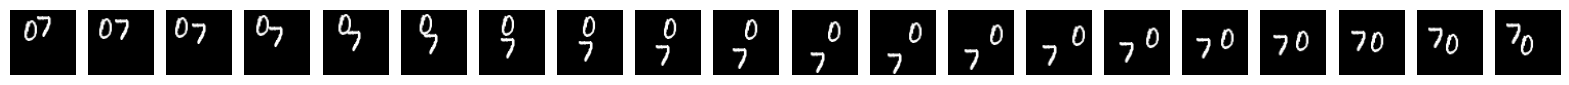

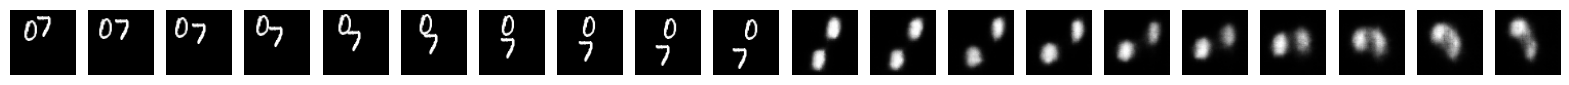

In [58]:
i = -5

pred = model(x[i].unsqueeze(0).to(device), y[i].unsqueeze(0).to(device), 0)
pred = nn.functional.sigmoid(pred)
pred = pred.squeeze(0).cpu().detach().numpy()

all_frames_pred = np.concatenate((x[i], pred), axis=0)
all_frames = np.concatenate((x[i], y[i]), axis=0)

plt.figure(figsize=(20, 4))
for i in range(all_frames.shape[0]):
    plt.subplot(1, all_frames.shape[0], i+1)
    plt.imshow(all_frames[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.figure(figsize=(20, 4))
for i in range(all_frames_pred.shape[0]):
    plt.subplot(1, all_frames_pred.shape[0], i+1)
    plt.imshow(all_frames_pred[i].squeeze(), cmap="gray")
    plt.axis("off")

In [59]:
def display_frame(frame_number):
    plt.subplot(1, 2, 1)
    plt.title("Predicted")
    plt.imshow(all_frames_pred[frame_number].squeeze(), cmap="gray")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("GT")
    plt.imshow(all_frames[frame_number].squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

frame_slider = widgets.IntSlider(min=0, max=all_frames_pred.shape[0] - 1, step=1, description='Frame')
widgets.interact(display_frame, frame_number=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=19), Output()), _dom_classes=('widget-intera…

<function __main__.display_frame(frame_number)>

Observations:
- As we go deeper into the temporal dimension, the information regarding class digit fades
- The dynamics remain well-predicted, meaning that the `Seq2Seq` model successfully retains & uses information from previous frames
- The `ImageEncoder` and `ImageDecoder` could share some information in order for the digit structure to remain intact after decoding

### (Optional) Seq2Seq + Self-Attention

Let's add a `MultiheadAttention` attention module over the output temporal features:

<div style="text-align: center;">
  <img src="imgs/seq2seq_at.png" alt="description" width="1000"/>
  <figcaption>Seq2Seq + Self-Attention. <a href="https://blog.suriya.app/2016-12-31-practical-seq2seq/">Source</a></figcaption>
</div>

In [51]:
import importlib
import torch_utils
importlib.reload(torch_utils)

class ForecastModelAtt(nn.Module):
    def __init__(self, in_ch, inner_dim, n_lstm_layers, dropout):
        super().__init__()

        self.in_ch = in_ch
        self.inner_dim = inner_dim
        self.n_lstm_layers = n_lstm_layers
        self.drop = dropout

        self.im_enc = ImageEncoder(in_ch, inner_dim)
        self.im_dec = ImageDecoder(inner_dim, in_ch)

        self.seq2seq = Seq2Seq(inner_dim, n_lstm_layers, dropout)

        # this actually doesn't replicate the input to each head, but rather divides the input into n_heads and applies attention separately on each part
        # check the documentation
        self.att = nn.MultiheadAttention(inner_dim, num_heads=4, batch_first=True, dropout=0.5)
        
    def forward(self, source, target, teacher_forcing_ratio):

        b = source.shape[0]
        ts, tt = source.shape[1], target.shape[1]

        # Encode input frames
        source_ = einops.rearrange(source, "b t c h w -> (b t) c h w")
        source_ = self.im_enc(source_)
        source_ = einops.rearrange(source_, "(b t) c 1 1 -> b t c", b=b, t=ts)

        # Encode target frames
        target_ = einops.rearrange(target, "b t c h w -> (b t) c h w")
        target_ = self.im_enc(target_)
        target_ = einops.rearrange(target_, "(b t) c 1 1 -> b t c", b=b, t=tt)

        # Apply Seq2Seq
        ss_pred = self.seq2seq(source_, target_, teacher_forcing_ratio)

        # Apply attention
        ss_pred, att_weights = self.att(ss_pred, ss_pred, ss_pred)
        
        ss_pred_ = einops.rearrange(ss_pred, "b t c -> (b t) c 1 1")

        # Reconstruct next frames
        frame_pred = self.im_dec(ss_pred_)
        frame_pred = einops.rearrange(frame_pred, "(b t) c h w -> b t c h w", b=b, t=tt)
        
        return frame_pred

In [ ]:
in_ch = 1
inner_dim = 128
n_lstm_layers = 2
dropout = 0.2
teacher_forcing_ratio = 0.5

epochs = 5
lr = 1e-3
folder_path = "models/mmnist_att/"
file_name = "model.pth"

model_att = ForecastModelAtt(in_ch, inner_dim, n_lstm_layers, dropout)

optimizer = torch.optim.Adam(model_att.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, test_losses = torch_utils.train_loop_forecast(
    model_att, train_loader, optimizer, criterion, epochs, teacher_forcing_ratio,
    test_loader=test_loader, device=device, folder_path=folder_path, file_name=file_name
)

In [56]:
i = -5

pred = model(x[i].unsqueeze(0).to(device), y[i].unsqueeze(0).to(device), 0)
pred = nn.functional.sigmoid(pred)
pred = pred.squeeze(0).cpu().detach().numpy()

pred_att = model_att(x[i].unsqueeze(0).to(device), y[i].unsqueeze(0).to(device), 0)
pred_att = nn.functional.sigmoid(pred_att)
pred_att = pred_att.squeeze(0).cpu().detach().numpy()

all_frames_pred_att = np.concatenate((x[i], pred_att), axis=0)
all_frames_pred = np.concatenate((x[i], pred), axis=0)
all_frames = np.concatenate((x[i], y[i]), axis=0)


def display_frame(frame_number):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Predicted")
    plt.imshow(all_frames_pred[frame_number].squeeze(), cmap="gray")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Predicted Self-Att")
    plt.imshow(all_frames_pred_att[frame_number].squeeze(), cmap="gray")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("GT")
    plt.imshow(all_frames[frame_number].squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

frame_slider = widgets.IntSlider(min=0, max=all_frames_pred.shape[0] - 1, step=1, description='Frame')
widgets.interact(display_frame, frame_number=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=19), Output()), _dom_classes=('widget-intera…

<function __main__.display_frame(frame_number)>